### TP2.3 : états de marché

*Notebook fait par Alexandre Boistard, Ethan Trentin.*

#### 1. Détermination d’états de marché
— Télécharger la trame de clustering avec Leiden pour le clustering par la méthode de Leiden. 
1. Charger les données de rendements US.

In [43]:
from numpy import linalg as LA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sknetwork.clustering import Leiden
from scipy import sparse
from tqdm import tqdm

In [44]:
data = pd.read_parquet("sp500_20161229.parquet")
data.set_index("index", inplace=True)
data

,A,AA,AABA,ABC,ABT,ADBE,ADI,ADP,ADSK,AEE,...,WU,WY,XEL,XL,XLNX,XOM,XRX,YUM,ZBH,ZION
index,,,,,,,,,,,,,,,,,,,,,
2006-01-03,0.006308,0.011160,0.044155,0.020773,0.003043,0.049784,0.023139,0.009368,-0.004657,0.012100,...,NaN,0.004522,0.005959,0.012615,0.022213,0.040947,0.017747,-0.002773,0.015421,0.012176
2006-01-04,0.002687,0.005686,0.001467,-0.006626,0.001517,-0.009794,0.009264,0.003238,-0.005951,-0.005013,...,NaN,0.024160,0.004847,0.020519,0.044610,0.001710,-0.001341,0.008556,0.009492,0.007061
2006-01-05,0.026198,0.007981,0.013669,-0.012387,0.010856,-0.009110,0.031857,-0.008391,-0.014722,-0.008527,...,NaN,-0.008791,-0.000536,-0.001867,0.060566,-0.004951,-0.010745,0.042630,-0.010560,0.009089
2006-01-06,0.005222,-0.003299,0.040453,-0.011095,0.021229,0.024429,0.003925,0.008679,0.057798,0.014660,...,NaN,0.001478,0.003753,0.001583,0.019615,0.019732,-0.006110,-0.002848,-0.005117,0.010422
2006-01-09,-0.002886,0.011255,0.004860,0.000000,0.037173,-0.015641,0.014073,-0.002581,-0.014676,-0.004816,...,NaN,-0.002362,-0.002671,0.006752,-0.000687,-0.000505,0.013661,0.007752,0.035415,-0.008277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,-0.025323,-0.028534,-0.050340,-0.013690,-0.018889,-0.016213,-0.009486,-0.017686,-0.049520,0.016530,...,-0.017029,-0.006742,0.029647,-0.000712,-0.018732,-0.020152,-0.035985,-0.022026,-0.009216,-0.015853
2018-06-26,0.012745,0.034794,0.000530,-0.019844,0.000658,0.010723,0.005706,-0.011271,0.003237,0.004862,...,-0.007700,0.022342,0.003987,-0.000356,0.007636,0.011287,-0.004715,0.018068,0.016527,-0.010983
2018-06-27,-0.013553,-0.001310,-0.031391,-0.006306,-0.005262,-0.018865,-0.022389,-0.014953,-0.019590,0.009176,...,-0.015034,-0.014385,0.007942,-0.002674,-0.022583,0.013269,-0.032373,-0.014248,-0.022210,-0.018138


2. Choisir une taille de fenêtre de calibration T.

In [45]:
T = 50 # Nombre de points dans la fenêtre de calibration

3. Choisir un univers de titres (colonnes). Rappel : pour la détermination des états de marché, N > T est
indispensable.

In [46]:
N = data.shape[1] # Taille de l'univers : pour le moment on prend tout
N

328

In [47]:
np.random.seed(42)
universe = sorted(np.random.choice(data.columns, N, replace=False))
df_universe = data[universe].copy()
df_universe

,A,AA,AABA,ABC,ABT,ADBE,ADI,ADP,ADSK,AEE,...,WU,WY,XEL,XL,XLNX,XOM,XRX,YUM,ZBH,ZION
index,,,,,,,,,,,,,,,,,,,,,
2006-01-03,0.006308,0.011160,0.044155,0.020773,0.003043,0.049784,0.023139,0.009368,-0.004657,0.012100,...,NaN,0.004522,0.005959,0.012615,0.022213,0.040947,0.017747,-0.002773,0.015421,0.012176
2006-01-04,0.002687,0.005686,0.001467,-0.006626,0.001517,-0.009794,0.009264,0.003238,-0.005951,-0.005013,...,NaN,0.024160,0.004847,0.020519,0.044610,0.001710,-0.001341,0.008556,0.009492,0.007061
2006-01-05,0.026198,0.007981,0.013669,-0.012387,0.010856,-0.009110,0.031857,-0.008391,-0.014722,-0.008527,...,NaN,-0.008791,-0.000536,-0.001867,0.060566,-0.004951,-0.010745,0.042630,-0.010560,0.009089
2006-01-06,0.005222,-0.003299,0.040453,-0.011095,0.021229,0.024429,0.003925,0.008679,0.057798,0.014660,...,NaN,0.001478,0.003753,0.001583,0.019615,0.019732,-0.006110,-0.002848,-0.005117,0.010422
2006-01-09,-0.002886,0.011255,0.004860,0.000000,0.037173,-0.015641,0.014073,-0.002581,-0.014676,-0.004816,...,NaN,-0.002362,-0.002671,0.006752,-0.000687,-0.000505,0.013661,0.007752,0.035415,-0.008277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,-0.025323,-0.028534,-0.050340,-0.013690,-0.018889,-0.016213,-0.009486,-0.017686,-0.049520,0.016530,...,-0.017029,-0.006742,0.029647,-0.000712,-0.018732,-0.020152,-0.035985,-0.022026,-0.009216,-0.015853
2018-06-26,0.012745,0.034794,0.000530,-0.019844,0.000658,0.010723,0.005706,-0.011271,0.003237,0.004862,...,-0.007700,0.022342,0.003987,-0.000356,0.007636,0.011287,-0.004715,0.018068,0.016527,-0.010983
2018-06-27,-0.013553,-0.001310,-0.031391,-0.006306,-0.005262,-0.018865,-0.022389,-0.014953,-0.019590,0.009176,...,-0.015034,-0.014385,0.007942,-0.002674,-0.022583,0.013269,-0.032373,-0.014248,-0.022210,-0.018138


4. Pour chaque fenêtre de calibration :
- supprimez les colonnes avec des NA
- appliquer l’algorithme de Leiden selon la méthode de MacMahon et Garlaschelli pour obtenir les états
$\mu_t, t \in \{t_0,t_1, ..., T\}$, $n_p$ fois (e.g. $n_p$ = 20)

In [48]:
# On flag par fenêtre de calibration de taille T mais à l'envers
df_universe = df_universe.sort_index(ascending=False)
df_universe["calibration"] = (np.arange(df_universe.shape[0]) // T)
df_universe = df_universe.sort_index(ascending = True)
df_universe = df_universe[df_universe["calibration"] < df_universe["calibration"].max()]
df_universe.tail()

,A,AA,AABA,ABC,ABT,ADBE,ADI,ADP,ADSK,AEE,...,WY,XEL,XL,XLNX,XOM,XRX,YUM,ZBH,ZION,calibration
index,,,,,,,,,,,,,,,,,,,,,
2018-06-25,-0.025323,-0.028534,-0.050340,-0.013690,-0.018889,-0.016213,-0.009486,-0.017686,-0.049520,0.016530,...,-0.006742,0.029647,-0.000712,-0.018732,-0.020152,-0.035985,-0.022026,-0.009216,-0.015853,0
2018-06-26,0.012745,0.034794,0.000530,-0.019844,0.000658,0.010723,0.005706,-0.011271,0.003237,0.004862,...,0.022342,0.003987,-0.000356,0.007636,0.011287,-0.004715,0.018068,0.016527,-0.010983,0
2018-06-27,-0.013553,-0.001310,-0.031391,-0.006306,-0.005262,-0.018865,-0.022389,-0.014953,-0.019590,0.009176,...,-0.014385,0.007942,-0.002674,-0.022583,0.013269,-0.032373,-0.014248,-0.022210,-0.018138,0
2018-06-28,0.002453,0.015960,0.017503,-0.041416,0.012895,0.008962,-0.005699,0.008868,0.020530,0.005786,...,0.013472,-0.000657,0.002324,0.009924,0.003182,-0.005300,-0.012426,0.013209,0.002262,0
2018-06-29,0.008974,0.008823,-0.016127,-0.009640,-0.004570,0.016680,-0.000313,-0.000819,0.006526,0.000164,...,0.009693,0.000438,-0.002140,0.001996,0.009272,-0.005387,0.004237,0.001528,-0.009028,0


Maintenant complétons le code de l'algorithme de Leiden. 

In [49]:
def compute_filtered_C(R):
    C = np.corrcoef(R, rowvar=False)
    q = T/N
    lambda_plus = (1 + np.sqrt(q))**2
    lambda_, v = LA.eigh(C)
    lambda_filtered = np.where(lambda_ > lambda_plus, lambda_, 0)
    C_s = np.dot(v, np.dot(np.diag(lambda_filtered), v.T))
    return C_s

def LeidenCorrelationClustering(C_s):   # C_s is the filtered correlation matrix

    # Ensure the positivity of the filtered correlation matrix
    C_s = np.abs(C_s)

    adjacency = sparse.csr_matrix(C_s)   # C_s is not sparse but it is the only current format that works for now.

    leiden = Leiden()
    labels = leiden.fit_predict(adjacency)

    return labels

In [50]:
mu_array = np.zeros(T)

In [51]:

def process(df):
    mu_array = []
    for i in tqdm(range(np.max(df["calibration"])+1)):
        df_i=df[df["calibration"]==i]
        df_i=df_i.drop(columns=["calibration"])
        df_i = df_i.dropna(axis=1)
        C_s = compute_filtered_C(df_i)
        mu = LeidenCorrelationClustering(C_s)
        mu_array.append(mu)
    return mu_array

states = process(df_universe)

100%|██████████| 62/62 [00:03<00:00, 19.48it/s]


In [52]:
print(len(states))

62




5. Tracez le nombre d’états de marché en fonction du temps.

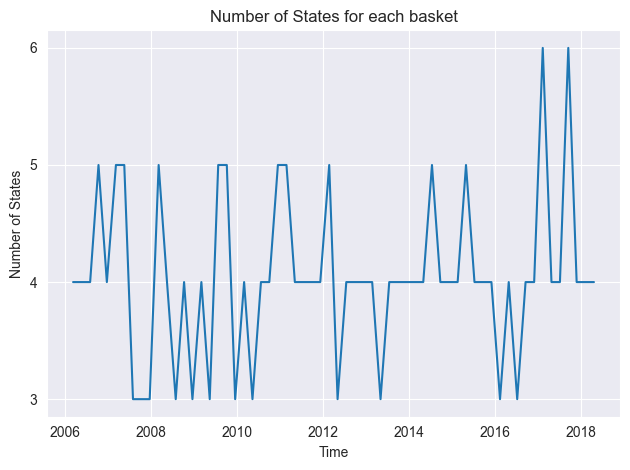

In [53]:
from matplotlib.ticker import MaxNLocator

times = []
nb_states = []
for i in range(len(states)):
    times.append(df_universe[df_universe["calibration"] == i].index[0])
    nb_states.append(max(states[i]) + 1)

plt.plot(times, nb_states)
plt.title("Number of States for each basket")
plt.xlabel("Time")
plt.ylabel("Number of States")

# Ensure y-axis shows only integer ticks
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.grid(True)
plt.tight_layout()
plt.show()

### Rolling window strategy

In [54]:
def rolling_window_strategy(df_, window_size=T, fees=0.0001):
    daily_returns = []
    df = df_.copy()
    df = df.sort_index()

    for start in tqdm(range(len(df) - window_size - 1)):
        end = start + window_size

        # Window data
        window_data = df.iloc[start:end].dropna(axis=1, how='any')
        next_day_returns = df.iloc[end]

        if window_data.shape[1] == 0:
            continue

        # Clustering
        C_s = compute_filtered_C(window_data.values)
        labels = LeidenCorrelationClustering(C_s)

        # Identify best-performing cluster
        mean_returns = window_data.mean()
        assets = window_data.columns
        cluster_perf = {}
        for label in np.unique(labels):
            cluster_assets = assets[labels == label]
            cluster_perf[label] = mean_returns[cluster_assets].mean()

        best_cluster = max(cluster_perf, key=cluster_perf.get)
        best_assets = assets[labels == best_cluster]

        portfolio_return = (next_day_returns[best_assets]-2*fees).mean()
        daily_returns.append(portfolio_return)

    return daily_returns

In [55]:
# Execute rolling window strategy
daily_strategy_returns = rolling_window_strategy(df_universe.drop
                                                 (columns=["calibration"]), fees=0.0001)

# Quick check of first few returns
print(daily_strategy_returns[:5])

100%|██████████| 3049/3049 [03:13<00:00, 15.74it/s]

[np.float64(0.003328460800984574), np.float64(-0.010819315597835279), np.float64(0.0014964912350495772), np.float64(-0.006841762681771005), np.float64(0.019207212215611738)]


### NN Strategy

In [56]:
def neighbors_strategy_nn(df_, window_size=T,fees=0.0001):
    daily_returns = []
    historical_states = []
    df = df_.copy().sort_index()
    
    # Calculate the number of full windows we can process.
    num_windows = (len(df) // window_size) - 1  # Ensure we have next period data
    
    for i in tqdm(range(num_windows)):
        start = i * window_size
        end = start + window_size
        # Calibration window: T days of data
        window_data = df.iloc[start:end].dropna(axis=1, how='any')
        # Next period returns: next T days of data
        next_period_returns = df.iloc[end:end+window_size]
        
        if window_data.shape[1] == 0:
            # If no valid data, fill with NaNs for the period and continue.
            daily_returns.extend([np.nan] * window_size)
            continue

        # Apply clustering on window data
        C_s = compute_filtered_C(window_data.values)
        labels = LeidenCorrelationClustering(C_s)

        # Compute mean returns for each asset in the calibration window
        mean_returns = window_data.mean()
        assets = window_data.columns

        # Compute the average performance for each cluster
        cluster_perf = {}
        for label in np.unique(labels):
            cluster_assets = assets[labels == label]
            cluster_perf[label] = mean_returns[cluster_assets].mean()

        # Define current state signature as the best cluster’s average return
        current_best_cluster = max(cluster_perf, key=cluster_perf.get)
        current_state_signature = cluster_perf[current_best_cluster]
        current_best_assets = assets[labels == current_best_cluster]

        # Nearest neighbor selection from historical states if available
        if historical_states:
            distances = [abs(current_state_signature - hist_state) for hist_state, _ in historical_states]
            nn_index = np.argmin(distances)
            selected_assets = historical_states[nn_index][1]
        else:
            selected_assets = current_best_assets

        # Calculate the daily returns for the next period using the selected assets.
        # We average across the selected assets (axis=1) to get an equal-weighted portfolio return per day.
        portfolio_daily_returns = (
            (next_period_returns[selected_assets]-2*fees).mean(axis=1))
        
        # Append these daily returns to our list
        daily_returns.extend(portfolio_daily_returns.tolist())
        
        # Record the current state for future nearest-neighbor comparisons.
        historical_states.append((current_state_signature, current_best_assets))
    daily_returns.pop()
    return daily_returns

In [57]:
daily_strategy_returns_nn = neighbors_strategy_nn(df_universe.drop
                                                  (columns=["calibration"]),
                                                  fees=0.0001)

100%|██████████| 61/61 [00:06<00:00,  9.39it/s]


### NN + rolling window strategy

In [58]:
def neighbors_rolling_strategy_nn(df_, window_size=T,fees=0.0001):
    daily_returns = []
    historical_states = []
    df = df_.copy()
    df = df.sort_index()
    for start in tqdm(range(len(df) - window_size - 1)):
        end = start + window_size
        # Extract the calibration window and next day’s returns
        window_data = df.iloc[start:end].dropna(axis=1, how='any')
        next_day_returns = df.iloc[end]

        if window_data.shape[1] == 0:
            continue

        # Apply clustering on window data
        C_s = compute_filtered_C(window_data.values)
        labels = LeidenCorrelationClustering(C_s)

        # Compute mean returns for each asset in the window
        mean_returns = window_data.mean()
        assets = window_data.columns

        # Compute performance for each cluster (state) as the mean of its assets’ returns
        cluster_perf = {}
        for label in np.unique(labels):
            cluster_assets = assets[labels == label]
            cluster_perf[label] = mean_returns[cluster_assets].mean()

        current_best_cluster = max(cluster_perf, key=cluster_perf.get)
        current_state_signature = cluster_perf[current_best_cluster]
        current_best_assets = assets[labels == current_best_cluster]

        # Use nearest neighbor approach if we have historical states recorded.
        if historical_states:
            distances = [abs(current_state_signature - hist_state) for hist_state, _ in historical_states]
            nn_index = np.argmin(distances)
            selected_assets = historical_states[nn_index][1]
        else:
            selected_assets = current_best_assets

        portfolio_return = (next_day_returns[selected_assets]-2*fees).mean()
        daily_returns.append(portfolio_return)
        historical_states.append((current_state_signature, current_best_assets))

    return daily_returns

In [59]:
daily_strategy_returns_nn_roll = neighbors_rolling_strategy_nn(df_universe.drop(columns=["calibration"]),fees=0.0001)

100%|██████████| 3049/3049 [03:14<00:00, 15.70it/s]


In [60]:
def plot_cumulative_returns(returns, df, window_size=T):
    returns = np.array(returns)
    cumulative_returns = np.cumprod(1 + returns)

    # Generate correct date index (1 day after each window ends)
    dates = df.index[window_size + 1 : window_size + 1 + len(returns)]

    return dates, cumulative_returns

In [61]:
import yfinance as yf
df_SPX = pd.DataFrame()
tickers = ["^GSPC"]
for ticker in tickers:
    df_SPX[ticker] = yf.download(ticker, start="2006-01-01", end="2018-06-29")["Close"]

[*********************100%***********************]  1 of 1 completed


In [62]:
dates, cumulative_returns = plot_cumulative_returns(daily_strategy_returns, df_universe)
dates_nn, cumulative_returns_nn = plot_cumulative_returns(daily_strategy_returns_nn, df_universe)
dates_nn_roll, cumulative_returns_nn_roll = plot_cumulative_returns(daily_strategy_returns_nn_roll,df_universe)

In [63]:
assert len(dates) == len(cumulative_returns), \
    f"Length mismatch: dates ({len(dates)}) vs cumulative_returns ({len(cumulative_returns)})"

assert len(dates_nn) == len(cumulative_returns_nn), \
    f"Length mismatch: dates_nn ({len(dates_nn)}) vs cumulative_returns_nn ({len(cumulative_returns_nn)})"

assert len(dates_nn_roll) == len(cumulative_returns_nn_roll), \
    f"Length mismatch: dates_nn_roll ({len(dates_nn_roll)}) vs cumulative_returns_nn_roll ({len(cumulative_returns_nn_roll)})"

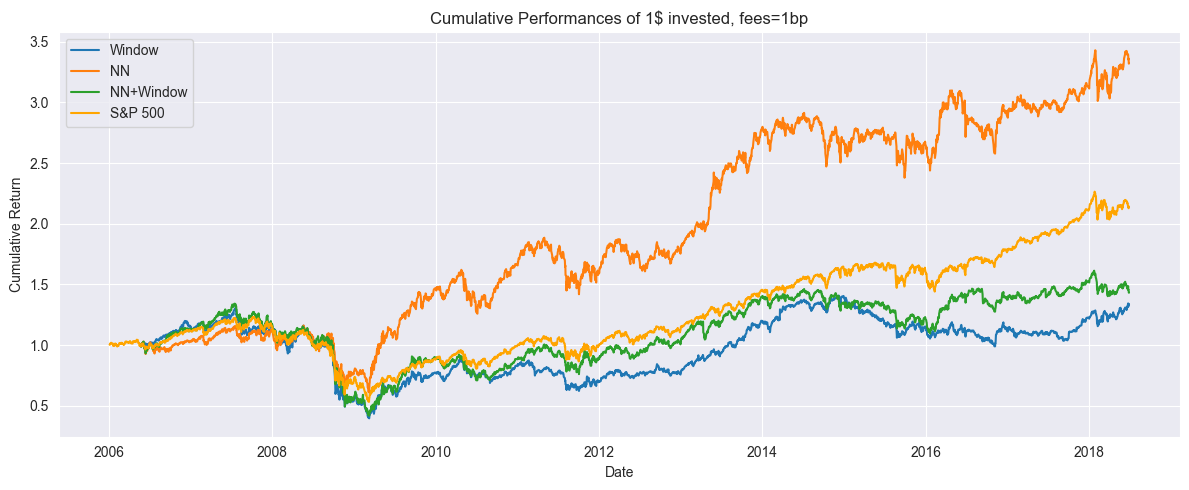

In [67]:
plt.figure(figsize=(12, 5))
plt.plot(dates, cumulative_returns, label="Window")
plt.plot(dates_nn, cumulative_returns_nn, label="NN")
plt.plot(dates_nn_roll, cumulative_returns_nn_roll, label="NN+Window")
plt.plot(df_SPX.index, (1 + df_SPX["^GSPC"].pct_change()).cumprod(), label="S&P 500", color="orange")


plt.title("Cumulative Performances of 1$ invested, fees=1bp")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [65]:
def compute_performance_metrics(returns):
    returns = np.array(returns)
    cumulative_return = np.prod(1 + returns) - 1
    annualized_return = np.mean(returns) * 252
    annualized_volatility = np.std(returns) * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan
    
    perf = {
        'cumulative_return (in %)': str(round(cumulative_return*100,1)),
        'annualized_return (in %)': str(round(annualized_return*100,2)),
        'annualized_volatility': str(round(annualized_volatility,2)),
        'sharpe_ratio': str(round(sharpe_ratio,2))
    }
    
    return perf

In [66]:
# Compute strategy performance metrics
performance = compute_performance_metrics(daily_strategy_returns)
performance_nn = compute_performance_metrics(daily_strategy_returns_nn)
performance_nn_roll = compute_performance_metrics(daily_strategy_returns_nn_roll)
spx_performance = compute_performance_metrics((df_SPX["^GSPC"].pct_change()
                                                .dropna()))
# Display results
print("Performance Metrics:WINDOW")
print(performance)
print("Performance Metrics:NN")
print(performance_nn)
print("Performance Metrics:NN+WINDOW")
print(performance_nn_roll)
print("Performance Metrics:SPX")
print(spx_performance)

Performance Metrics:WINDOW
{'cumulative_return (in %)': '33.8', 'annualized_return (in %)': '5.31', 'annualized_volatility': '0.24', 'sharpe_ratio': '0.22'}
Performance Metrics:NN
{'cumulative_return (in %)': '232.0', 'annualized_return (in %)': '12.56', 'annualized_volatility': '0.23', 'sharpe_ratio': '0.55'}
Performance Metrics:NN+WINDOW
{'cumulative_return (in %)': '43.2', 'annualized_return (in %)': '5.96', 'annualized_volatility': '0.24', 'sharpe_ratio': '0.24'}
Performance Metrics:SPX
{'cumulative_return (in %)': '114.1', 'annualized_return (in %)': '7.97', 'annualized_volatility': '0.19', 'sharpe_ratio': '0.41'}
